### 1. 生成单条指令，并设置对应的数据

In [2]:
from cimCommand import CMD,CmdData
from cimCommand.singleCmdInfo import *

# 指令所需数据
data=CmdData((1<<24)|7)
# 更改数据位
data.set_bit(3,1)               # 设置数据的第三位为1
data.replace_bit(8,3,22)        # 设置数据从第[8位开始到11)，用22的低三位替换,22中超过3bit会被截断

# 对应的指令，DAC_IN为指令相关信息，如果不设置command_data，就会用DAC_IN里面的默认信息初始化
cmd=CMD(DAC_IN,command_data=data)
print(cmd)

cmd=CMD(DAC_IN,command_data=CmdData((1<<24)|7))
print(cmd)

地址:	2
类型:	RW
位宽:	32 bit
名字:	dac_in
数据:	16778767
字节:	b'\x02\x01\x00\x06\x0f'
描述:	高8bit：0或1，选择dac。低24bit：spi写入DAC寄存器的24bit值

地址:	2
类型:	RW
位宽:	32 bit
名字:	dac_in
数据:	16777223
字节:	b'\x02\x01\x00\x00\x07'
描述:	高8bit：0或1，选择dac。低24bit：spi写入DAC寄存器的24bit值



### 2. 生成指令，并组合成packet数据

In [3]:
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

In [4]:
# 生成packet
pck=Packet()


# 生成对应的指令
cmd_list=[CMD(DAC_IN,command_data=CmdData(7)),CMD(DAC_IN,command_data=CmdData(8)),CMD(DAC_IN,command_data=CmdData(9))]
# 将指令加入packet中
pck.append_single(cmd_list,mode=0)
print(pck)


# 生成对应的指令
cmd_list=[CMD(DAC_IN,command_data=CmdData(7))]
# 将指令加入packet中
pck.append_single(cmd_list,mode=1)
print(pck)


cmd_list=[CMD(DAC_IN,command_data=CmdData(7))]
pck.append_single(cmd_list,mode=2)
print(pck)


cmd_list=[CMD(DAC_IN,command_data=CmdData(7))]
pck.append_single(cmd_list,mode=3)
print(pck)

模式：0,指令：dac_in,指令：dac_in,指令：dac_in
字节码：55 aa 00 02 00 00 00 07 02 00 00 00 08 02 00 00 00 09

模式：0,指令：dac_in,指令：dac_in,指令：dac_in
字节码：55 aa 00 02 00 00 00 07 02 00 00 00 08 02 00 00 00 09
模式：1,指令：dac_in
字节码：55 aa 01 02 00 00 00 07

模式：0,指令：dac_in,指令：dac_in,指令：dac_in
字节码：55 aa 00 02 00 00 00 07 02 00 00 00 08 02 00 00 00 09
模式：1,指令：dac_in
字节码：55 aa 01 02 00 00 00 07
模式：2,指令：dac_in
字节码：55 aa 02 02

模式：0,指令：dac_in,指令：dac_in,指令：dac_in
字节码：55 aa 00 02 00 00 00 07 02 00 00 00 08 02 00 00 00 09
模式：1,指令：dac_in
字节码：55 aa 01 02 00 00 00 07
模式：2,指令：dac_in
字节码：55 aa 02 02
模式：3,指令：dac_in
字节码：55 aa 03



### 3. 将packet的数据发送到下位机

In [2]:
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *
from pc import PS
import socket


In [ ]:
# 连接下位机
ps = PS("192.168.1.10", 7,debug=True)

# 打包成packet，包括指令
packet=Packet()
cmd_list=[CMD(DAC_IN,command_data=CmdData(7))]
packet.append_cmdlist(cmd_list,mode=1)

try:
    ps.send_packets(packet)                                     # 发送
    # packet = ps.receive_packet()                                # 接收
    print(packet)                                               # 打印
except Exception as e:
    print(f"Failed to connect: {e}")
finally:
    ps.close()

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 61702
------------------------------ 发送指令: ------------------------------ 
模式：1,指令：dac_in
字节码：55 aa 01 02 00 00 00 07

------------------------------ 指令发送完成！------------------------------ 



### 4. 控制下位机执行相关指令

In [98]:
from modules import ADC,DAC,CHIP
from pc import PS
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

In [99]:
# 用于和下位机交互通信
ps=PS("192.168.1.10", 7,delay=0.3,debug=False)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 57571


In [101]:
# 控制ADC
adc=ADC(ps)
# 控制DAC
dac=DAC(ps)
# 芯片，读写操作，device_cfg
chip=CHIP(adc,dac,ps)

In [195]:
# ps.close()

Connection closed.


In [102]:
adc.set_gain(3)

In [103]:
chip.set_device_cfg(deviceType=1)

In [104]:

def adc_to_voltage(data, vref=1.25):
    # 将十六进制字符串转换为整数
    data = int(data, 16)
    # 确保数据在16位范围内
    data &= 0xFFFF
    # 将16位有符号数转换为Python整数
    if data & 0x8000:  # 若符号位为1，则表示负数
        data -= 0x10000

    # 将数据转换为电压
    voltage = (data / (2**15-1)) * vref  # 32767 是0x7FFF对应的正最大值
    return voltage

In [105]:
# ps.delay = 0.3
ps.debug = True

In [136]:
pkts=Packet()
pkts.append_cmdlist([
    CMD(FLT,command_data=CmdData(0x0E0F)),                      # 配置flt
],mode=1)

# 发送指令
ps.send_packets(pkts)



模式：1,指令：flt
字节码：55 aa 01 09 00 00 0e 0f



In [107]:
def numToBank_Index(num:int):
    """
        注意：num从0索引开始
        将x,y译码为对应的bank和index
        bank和index均从0开始，方便后面的位操作
    """
    num += 1
    assert num > 0 and num < 257,"numToBank_Index: num超过范围!"
    # 先判断奇数偶数
    if num&1:
        index_base,index_offset = 64,1
        bank_base = 0
    else:
        index_base,index_offset = 64,2
        bank_base = 4

    bank_offset = int((num-index_offset)/index_base)
    bank = bank_base + bank_offset
    index = int((num - index_offset - bank_offset * index_base) / 2)

    return bank, index

In [108]:
print(numToBank_Index(32))

(0, 16)


In [109]:
def get_data(num:list):
    bank,index = 0,0
    for i in num:
        bank_tmp,index_tmp = chip.numToBank_Index(i)
        bank = bank | (1<<bank_tmp)
        index = index | (1<<index_tmp)
    return bank,index

In [110]:
rowdatares=[]

In [111]:
colnum=[i*32 for i in range(8)]+[i*32+1 for i in range(8)]

print(colnum)

[0, 32, 64, 96, 128, 160, 192, 224, 1, 33, 65, 97, 129, 161, 193, 225]


In [149]:
pkts=Packet()
pkts.append_cmdlist([
    # CMD(CIM_RESET,command_data=CmdData(0)),
    CMD(CIM_RESET,command_data=CmdData(1)),
],mode=1)                 # reset指令
ps.send_packets(pkts)



模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 01



In [207]:
# 配置行列的latch
# rownum=[[19],[128],[240]]
rownum=[[19],[20]]
colnum=[[225]]
# colnum=[[0,32], [64,96], [128,160], [192,224], [1,33], [65,97], [129,161], [193,225]]
pkts=Packet()
pkts.append_cmdlist([
    CMD(CIM_RESET,command_data=CmdData(0)),
    CMD(CIM_RESET,command_data=CmdData(1)),
],mode=1)                 # reset指令
ps.send_packets(pkts)

# 配置行
for i in rownum:
    xbank,xindex = get_data(i)
    pkts=Packet()
    pkts.append_cmdlist([
        # 行reg配置
        CMD(CIM_DATA_IN,command_data=CmdData(xindex)),       # 第xindex位置1
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

        # 行bank配置
        CMD(ROW_COL_SEL,command_data=CmdData(1)),               # 设置为行模式
        CMD(CIM_BANK_SEL,command_data=CmdData(xbank)),       # 行bank选择
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
    ],mode=1)
    ps.send_packets(pkts)

# for i in range(0,8):
#     pkts=Packet()
#     pkts.append_cmdlist([
#         # 行reg配置
#         CMD(CIM_DATA_IN,command_data=CmdData(0xFFFFFFFF)),       # 第xindex位置1
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

#         # 行bank配置
#         CMD(ROW_COL_SEL,command_data=CmdData(1)),               # 设置为行模式
#         CMD(CIM_BANK_SEL,command_data=CmdData(1<<i)),       # 行bank选择
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
#     ],mode=1)
#     ps.send_packets(pkts)
    
for i in range(8):
    pkts=Packet()
    pkts.append_cmdlist([
        # 行reg配置
        CMD(CIM_DATA_IN,command_data=CmdData(0xFFFFFFFF)),       # 第yindex位置1
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

        # 行bank配置
        CMD(ROW_COL_SEL,command_data=CmdData(0)),               # 设置为列模式
        CMD(CIM_BANK_SEL,command_data=CmdData(1<<i)),       # 行bank选择
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
    ],mode=1)
    ps.send_packets(pkts)

# 配置列
# ybank
# for i in colnum:
#     ybank,yindex = get_data(i)
    
#     pkts=Packet()
#     pkts.append_cmdlist([
#         # 列reg配置
#         CMD(CIM_DATA_IN,command_data=CmdData(yindex)),       # 第yindex位置1
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

#         # 列bank配置
#         CMD(ROW_COL_SEL,command_data=CmdData(0)),               # 设置为列模式
#         CMD(CIM_BANK_SEL,command_data=CmdData(ybank)),       # 列bank选择
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
#     ],mode=1)
#     ps.send_packets(pkts)

# 设置为read模式
pkts=Packet()
pkts.append_cmdlist([
    CMD(ROW_CTRL,command_data=CmdData(1)),                  # 配置行到施加电压
    CMD(COL_CTRL,command_data=CmdData(0)),                  # 配置列到TIA  
])
ps.send_packets(pkts)

v = 0.1
dac.set_voltage(0.1,dac_num=0,dac_channel=0)           # ROW_Va电压
dac.set_voltage(0.1,dac_num=0,dac_channel=1)           # ROW_Va电压
dac.set_voltage(0.1,dac_num=0,dac_channel=2)           # ROW_Va电压
dac.set_voltage(0.1,dac_num=0,dac_channel=3)           # ROW_Va电压


dac.set_voltage(0,dac_num=0,dac_channel=4)           # COL_Va电压
dac.set_voltage(0,dac_num=0,dac_channel=5)           # COL_Va电压
dac.set_voltage(0,dac_num=0,dac_channel=6)           # COL_Va电压
dac.set_voltage(0,dac_num=0,dac_channel=7)           # COL_Va电压


dac.set_voltage(0,dac_num=1,dac_channel=0)           # ROW_Vc
dac.set_voltage(0,dac_num=1,dac_channel=1)           # COL_Vc     
dac.set_voltage(0,dac_num=1,dac_channel=2)           # GL
dac.set_voltage(0,dac_num=1,dac_channel=3)           # GR

# 设置PCB的TIA，为列
pkts=Packet()
pkts.append_cmdlist([
    CMD(ROW_COL_SW,command_data=CmdData(1)),
],mode=1)

# 发送指令
ps.send_packets(pkts)

# # 设置ADC采样点数
# chip.adc.set_sample_times(32)

pkts=Packet()
pkts.append_cmdlist([
    CMD(PULSE_CYC,command_data=CmdData(0)),                                                 # 翻转
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，配置列为常1
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，读完后，把列电压翻转为0
],mode=1)
chip.ps.send_packets(pkts)




模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 00
模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 01



模式：1,指令：cim_data_in
字节码：55 aa 01 08 00 00 02 00
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 20
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 02 00
模式：1,指令：row_col_sel
字节码：55 aa 01 0f 00 00 00 01
模式：1,指令：cim_bank_sel
字节码：55 aa 01 0a 00 00 00 10
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 40
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 04 00



模式：1,指令：cim_data_in
字节码：55 aa 01 08 00 00 04 00
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 20
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 02 00
模式：1,指令：row_col_sel
字节码：55 aa 01 0f 00 00 00 01
模式：1,指令：cim_bank_sel
字节码：55 aa 01 0a 00 00 00 01
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 40
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 04 00



模式：1,指令：cim_data_in
字节码：55 aa 01 08 ff ff ff ff
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 20
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 02 00
模式：1,指令：row_col_sel
字节码：55 aa 01 0f 00 00 00 00
模

DAC: adc0_outA


模式：2,指令：adc0_outA
字节码：55 aa 02 41

Received: b'i\x00\x00\x00'

电压int:  0.004005554368724631
DAC: adc0_outB


模式：2,指令：adc0_outB
字节码：55 aa 02 42

Received: b'\xa2\xfe\xff\xff'

电压int:  -0.013351847895748772
DAC: adc0_outC


模式：2,指令：adc0_outC
字节码：55 aa 02 43

Received: b'\xa4\x00\x00\x00'

电压int:  0.006256294442579424
DAC: adc0_outD


模式：2,指令：adc0_outD
字节码：55 aa 02 44

Received: b'\xbf\x00\x00\x00'

电压int:  0.00728629413739433
DAC: adc1_outA


模式：2,指令：adc1_outA
字节码：55 aa 02 45

Received: b'\xa5\x12\x00\x00'

电压int:  0.18208105716116824
DAC: adc1_outB


模式：2,指令：adc1_outB
字节码：55 aa 02 46

Received: b'9\x10\x00\x00'

电压int:  0.15842921231727042
DAC: adc1_outC


模式：2,指令：adc1_outC
字节码：55 aa 02 47

Received: b'u\x10\x00\x00'

电压int:  0.16071810052797023
DAC: adc1_outD


模式：2,指令：adc1_outD
字节码：55 aa 02 48

Received: b'\xc3\x11\x00\x00'

电压int:  0.17345957823419905
DAC: adc2_outA


模式：2,指令：adc2_outA
字节码：55 aa 02 49

Received: b'3\x10\x00\x00'

电压int:  0.15820032349620045
DAC: adc2

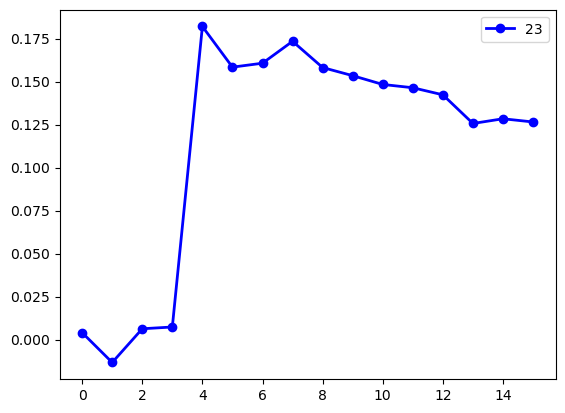

In [208]:
# pkts=Packet()
# pkts.append_cmdlist([CMD(CIM_RESET,command_data=CmdData(1))],mode=1)                 # reset指令
# ps.send_packets(pkts)

# pkts=Packet()
# pkts.append_cmdlist([
#     CMD(PULSE_CYC,command_data=CmdData(0)),                                                 # 翻转
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，配置列为常1
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，读完后，把列电压翻转为0
# ],mode=1)
# chip.ps.send_packets(pkts)


import matplotlib.pyplot as plt

tia16 = []
for TIA_num in range(16):
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    tia16.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)

plt.figure()
plt.plot( tia16, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.legend()
plt.show()
# 12TIA：0.39139988402966397
# 0.5483413190099796
# 0.561

In [217]:
pkts=Packet()
pkts.append_cmdlist([
    CMD(FLT,command_data=CmdData(0x00F0)),                      # 配置flt
],mode=1)

# 发送指令
ps.send_packets(pkts)



模式：1,指令：flt
字节码：55 aa 01 09 00 00 00 f0



In [233]:
# ----------------------------------------------------------------------------------列给电压，行接TIA
# rownum=[[19],[128],[240]]
rownum=[[19]]
colnum=[[225,226]]
# colnum=[[0,32], [64,96], [128,160], [192,224], [1,33], [65,97], [129,161], [193,225]]
pkts=Packet()
pkts.append_cmdlist([
    CMD(CIM_RESET,command_data=CmdData(0)),
    CMD(CIM_RESET,command_data=CmdData(1)),
],mode=1)                 # reset指令
ps.send_packets(pkts)

# 配置行
# for i in rownum:
#     xbank,xindex = get_data(i)
#     pkts=Packet()
#     pkts.append_cmdlist([
#         # 行reg配置
#         CMD(CIM_DATA_IN,command_data=CmdData(xindex)),       # 第xindex位置1
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

#         # 行bank配置
#         CMD(ROW_COL_SEL,command_data=CmdData(1)),               # 设置为行模式
#         CMD(CIM_BANK_SEL,command_data=CmdData(xbank)),       # 行bank选择
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
#     ],mode=1)
#     ps.send_packets(pkts)

for i in range(8):
    pkts=Packet()
    pkts.append_cmdlist([
        # 行reg配置
        CMD(CIM_DATA_IN,command_data=CmdData(0xFFFFFFFF)),       # 第xindex位置1
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

        # 行bank配置
        CMD(ROW_COL_SEL,command_data=CmdData(1)),               # 设置为行模式
        CMD(CIM_BANK_SEL,command_data=CmdData(1<<i)),       # 行bank选择
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
    ],mode=1)
    ps.send_packets(pkts)
    
# for i in range(8):
#     pkts=Packet()
#     pkts.append_cmdlist([
#         # 行reg配置
#         CMD(CIM_DATA_IN,command_data=CmdData(0xFFFFFFFF)),       # 第yindex位置1
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

#         # 行bank配置
#         CMD(ROW_COL_SEL,command_data=CmdData(0)),               # 设置为列模式
#         CMD(CIM_BANK_SEL,command_data=CmdData(1<<i)),       # 行bank选择
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
#         CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
#     ],mode=1)
#     ps.send_packets(pkts)

# 配置列
for i in colnum:
    ybank,yindex = get_data(i)
    
    pkts=Packet()
    pkts.append_cmdlist([
        # 列reg配置
        CMD(CIM_DATA_IN,command_data=CmdData(yindex)),       # 第yindex位置1
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

        # 列bank配置
        CMD(ROW_COL_SEL,command_data=CmdData(0)),               # 设置为列模式
        CMD(CIM_BANK_SEL,command_data=CmdData(ybank)),       # 列bank选择
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
    ],mode=1)
    ps.send_packets(pkts)

# 设置为read模式
pkts=Packet()
pkts.append_cmdlist([
    CMD(ROW_CTRL,command_data=CmdData(0)),                  
    CMD(COL_CTRL,command_data=CmdData(1)),                   
])
ps.send_packets(pkts)

v = 0.1
dac.set_voltage(0,dac_num=0,dac_channel=0)           # ROW_Va电压
dac.set_voltage(0,dac_num=0,dac_channel=1)           # ROW_Va电压
dac.set_voltage(0,dac_num=0,dac_channel=2)           # ROW_Va电压
dac.set_voltage(0,dac_num=0,dac_channel=3)           # ROW_Va电压


dac.set_voltage(0.1,dac_num=0,dac_channel=4)           # COL_Va电压
dac.set_voltage(0.1,dac_num=0,dac_channel=5)           # COL_Va电压
dac.set_voltage(0.1,dac_num=0,dac_channel=6)           # COL_Va电压
dac.set_voltage(0.1,dac_num=0,dac_channel=7)           # COL_Va电压


dac.set_voltage(0,dac_num=1,dac_channel=0)           # ROW_Vc
dac.set_voltage(0,dac_num=1,dac_channel=1)           # COL_Vc     
dac.set_voltage(0,dac_num=1,dac_channel=2)           # GL
dac.set_voltage(0,dac_num=1,dac_channel=3)           # GR

pkts=Packet()
pkts.append_cmdlist([
    CMD(ROW_COL_SW,command_data=CmdData(0)),
],mode=1)

# 发送指令
ps.send_packets(pkts)

# # 设置ADC采样点数
# chip.adc.set_sample_times(32)

pkts=Packet()
pkts.append_cmdlist([
    CMD(PULSE_CYC,command_data=CmdData(0)),                                                 # 翻转
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_pulse)),             # cfg_col_pulse，配置列为常1
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_read)),              # 然后开始读
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_pulse)),             # cfg_col_pulse，读完后，把列电压翻转为0
],mode=1)
chip.ps.send_packets(pkts)




模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 00
模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 01



模式：1,指令：cim_data_in
字节码：55 aa 01 08 ff ff ff ff
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 20
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 02 00
模式：1,指令：row_col_sel
字节码：55 aa 01 0f 00 00 00 01
模式：1,指令：cim_bank_sel
字节码：55 aa 01 0a 00 00 00 01
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 40
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 04 00



模式：1,指令：cim_data_in
字节码：55 aa 01 08 ff ff ff ff
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 20
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 02 00
模式：1,指令：row_col_sel
字节码：55 aa 01 0f 00 00 00 01
模式：1,指令：cim_bank_sel
字节码：55 aa 01 0a 00 00 00 02
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 40
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 04 00



模式：1,指令：cim_data_in
字节码：55 aa 01 08 ff ff ff ff
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 00 20
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 02 00
模式：1,指令：row_col_sel
字节码：55 aa 01 0f 00 00 00 01
模

DAC: adc0_outA


模式：2,指令：adc0_outA
字节码：55 aa 02 41

Received: b'w\x00\x00\x00'

电压int:  0.004539628284554583
DAC: adc0_outB


模式：2,指令：adc0_outB
字节码：55 aa 02 42

Received: b'\xb4\xfe\xff\xff'

电压int:  -0.012665181432538836
DAC: adc0_outC


模式：2,指令：adc0_outC
字节码：55 aa 02 43

Received: b'\xb1\x00\x00\x00'

电压int:  0.006752220221564379
DAC: adc0_outD


模式：2,指令：adc0_outD
字节码：55 aa 02 44

Received: b'\xa6\x13\x00\x00'

电压int:  0.19188512833033233
DAC: adc1_outA


模式：2,指令：adc1_outA
字节码：55 aa 02 45

Received: b'"\x13\x00\x00'

电压int:  0.1868495742667928
DAC: adc1_outB


模式：2,指令：adc1_outB
字节码：55 aa 02 46

Received: b'\xfa\x10\x00\x00'

电压int:  0.16579180272835475
DAC: adc1_outC


模式：2,指令：adc1_outC
字节码：55 aa 02 47

Received: b'\xe8\x10\x00\x00'

电压int:  0.1651051362651448
DAC: adc1_outD


模式：2,指令：adc1_outD
字节码：55 aa 02 48

Received: b'\x84\x0f\x00\x00'

电压int:  0.15152439954832606
DAC: adc2_outA


模式：2,指令：adc2_outA
字节码：55 aa 02 49

Received: b'{\x0e\x00\x00'

电压int:  0.141415143284402
DAC: adc2_

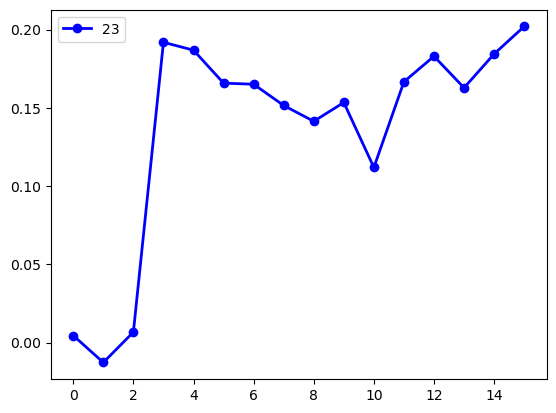

In [234]:
# pkts=Packet()
# pkts.append_cmdlist([CMD(CIM_RESET,command_data=CmdData(1))],mode=1)                 # reset指令
# ps.send_packets(pkts)

# pkts=Packet()
# pkts.append_cmdlist([
#     CMD(PULSE_CYC,command_data=CmdData(0)),                                                 # 翻转
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，配置列为常1
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，读完后，把列电压翻转为0
# ],mode=1)
# chip.ps.send_packets(pkts)


import matplotlib.pyplot as plt

tia16 = []
for TIA_num in range(16):
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    tia16.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)

plt.figure()
plt.plot( tia16, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.legend()
plt.show()
# 12TIA：0.39139988402966397
# 0.5483413190099796
# 0.561



模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 00
模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 01



模式：1,指令：pulse_cyc
字节码：55 aa 01 1b 00 00 00 00
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 10 00
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 20 00
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 10 00

DAC: adc0_outA


模式：2,指令：adc0_outA
字节码：55 aa 02 41

Received: b'i\x00\x00\x00'

电压int:  0.004005554368724631
DAC: adc0_outB


模式：2,指令：adc0_outB
字节码：55 aa 02 42

Received: b'\xa1\xfe\xff\xff'

电压int:  -0.01338999603259377
DAC: adc0_outC


模式：2,指令：adc0_outC
字节码：55 aa 02 43

Received: b'\xa2\x00\x00\x00'

电压int:  0.006179998168889431
DAC: adc0_outD


模式：2,指令：adc0_outD
字节码：55 aa 02 44

Received: b'\xbe\x00\x00\x00'

电压int:  0.007248146000549334
DAC: adc1_outA


模式：2,指令：adc1_outA
字节码：55 aa 02 45

Received: b'\xe8\x00\x00\x00'

电压int:  0.008850367748039186
DAC: adc1_outB


模式：2,指令：adc1_outB
字节码：55 aa 02 46

Received: b'\xe5\xff\xff\xff'

电压int:  -0.0010299996948149052
DAC: adc1_outC


模式：2,指令：adc1_ou

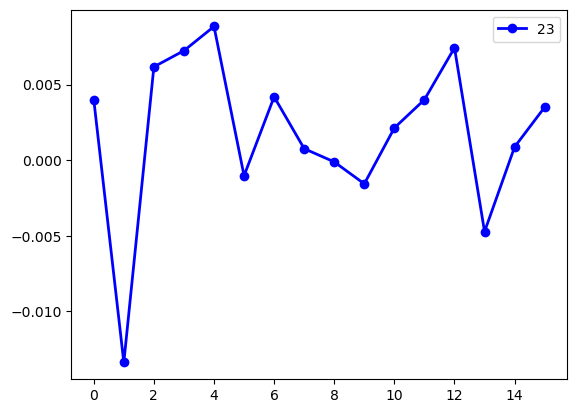

In [140]:
pkts=Packet()
pkts.append_cmdlist([
    CMD(CIM_RESET,command_data=CmdData(0)),
    CMD(CIM_RESET,command_data=CmdData(1))
],mode=1)                 # reset指令
ps.send_packets(pkts)

pkts=Packet()
pkts.append_cmdlist([
    CMD(PULSE_CYC,command_data=CmdData(0)),                                                 # 翻转
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，配置列为常1
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，读完后，把列电压翻转为0
],mode=1)
chip.ps.send_packets(pkts)


import matplotlib.pyplot as plt

tia16 = []
for TIA_num in range(16):
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    tia16.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)

plt.figure()
plt.plot( tia16, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.legend()
plt.show()
# 12TIA：0.39139988402966397
# 0.5483413190099796
# 0.561

------------------------------ 发送指令: ------------------------------ 
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 20 00

------------------------------ 指令发送完成！------------------------------ 

DAC: adc0_outA
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outA
字节码：55 aa 02 41

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'g\x00\x00\x00'

电压int:  0.003929258095034639
DAC: adc0_outB
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outB
字节码：55 aa 02 42

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'\x9e\xfe\xff\xff'

电压int:  -0.013504440443128757
DAC: adc0_outC
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outC
字节码：55 aa 02 43

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'\x9f\x00\x00\x00'

电压int:  0.006065553758354442
DAC: adc0_outD
------------------------------

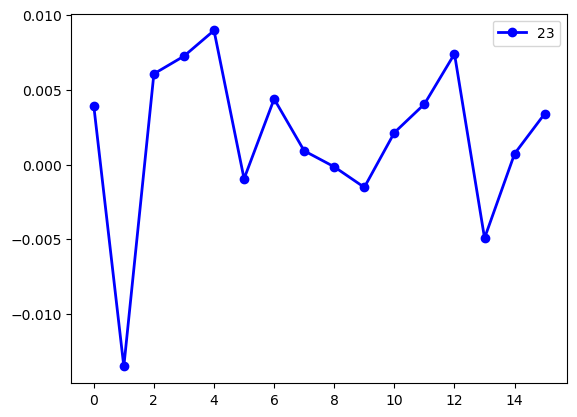

In [232]:
# pkts=Packet()
# pkts.append_cmdlist([CMD(CIM_RESET,command_data=CmdData(1))],mode=1)                 # reset指令
# ps.send_packets(pkts)

pkts=Packet()
pkts.append_cmdlist([
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
],mode=1)
ps.send_packets(pkts)


import matplotlib.pyplot as plt

tia16 = []
for TIA_num in range(16):
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    tia16.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)

plt.figure()
plt.plot( tia16, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.legend()
plt.show()

In [185]:
colnum_zero=[i for i in range(160,192,2)]
print(colnum_zero)

[160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190]


In [144]:
vres = []
cond_res = []
for i in colnum:
    for j in i:
        TIA_num = adc.TIA_index_map(j,1,True)
        adc_num, adc_channel = int(TIA_num/4),TIA_num%4

        channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        pkts=Packet()
        adc_out = CMD(dict(
            command_addr = 65+TIA_num,
            command_type = COMMAND_TYPE[1],
            n_addr_bytes = N_ADDR_BYTES[0],
            n_data_bytes = N_DATA_BYTES[0],
            command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
            command_data = CmdData(0),
            command_description = "从ADC对应通道读取数据"
        ))
        pkts.append_cmdlist([adc_out],mode=2)
        print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
        # 发送指令
        ps.send_packets(pkts)
        # 接收信息
        # 高16bit：0，低16bit：寄存器的16bit值
        message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

        voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
        # print("电压hex: ",voltage_sample_hex)
        voltage_sample_int = adc_to_voltage(voltage_sample_hex)
        vres.append(voltage_sample_int)
        print("电压int: ",voltage_sample_int)
        res_meas = 0.1 * (10e3+200) * 6.0241 / (voltage_sample_int+1e-10)
        cond_res.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'\x85\x11\x00\x00'

电压int:  0.17109439374980925


In [148]:
res_meas = 0.1 * (10e3+200) * 1 / (0.2+1e-10)
print(res_meas)

5099.99999745


In [147]:
vres2 = []
cond_res2 = []
for i in colnum:
    TIA_num = adc.TIA_index_map(i[0],1,True)
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    vres2.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)
    res_meas = 0.1 * (10e3+200) * 6.0241 / voltage_sample_int
    cond_res2.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'\x87\x11\x00\x00'

电压int:  0.17117069002349924


In [150]:
vres3 = []
cond_res3 = []
for i in colnum:
    for j in i:
        TIA_num = adc.TIA_index_map(j,1,True)
        adc_num, adc_channel = int(TIA_num/4),TIA_num%4

        channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        pkts=Packet()
        adc_out = CMD(dict(
            command_addr = 65+TIA_num,
            command_type = COMMAND_TYPE[1],
            n_addr_bytes = N_ADDR_BYTES[0],
            n_data_bytes = N_DATA_BYTES[0],
            command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
            command_data = CmdData(0),
            command_description = "从ADC对应通道读取数据"
        ))
        pkts.append_cmdlist([adc_out],mode=2)
        print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
        # 发送指令
        ps.send_packets(pkts)
        # 接收信息
        # 高16bit：0，低16bit：寄存器的16bit值
        message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

        voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
        # print("电压hex: ",voltage_sample_hex)
        voltage_sample_int = adc_to_voltage(voltage_sample_hex)
        vres3.append(voltage_sample_int)
        print("电压int: ",voltage_sample_int)
        res_meas = 0.1 * (10e3+200) * 6.0241 / (voltage_sample_int+1e-10)
        cond_res3.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'\x89\x11\x00\x00'

电压int:  0.17124698629718924


In [154]:
vres4 = []
cond_res4 = []
for i in colnum:
    for j in i:
        TIA_num = adc.TIA_index_map(j,1,True)
        adc_num, adc_channel = int(TIA_num/4),TIA_num%4

        channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        pkts=Packet()
        adc_out = CMD(dict(
            command_addr = 65+TIA_num,
            command_type = COMMAND_TYPE[1],
            n_addr_bytes = N_ADDR_BYTES[0],
            n_data_bytes = N_DATA_BYTES[0],
            command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
            command_data = CmdData(0),
            command_description = "从ADC对应通道读取数据"
        ))
        pkts.append_cmdlist([adc_out],mode=2)
        print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
        # 发送指令
        ps.send_packets(pkts)
        # 接收信息
        # 高16bit：0，低16bit：寄存器的16bit值
        message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

        voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
        # print("电压hex: ",voltage_sample_hex)
        voltage_sample_int = adc_to_voltage(voltage_sample_hex)
        vres4.append(voltage_sample_int)
        print("电压int: ",voltage_sample_int)
        res_meas = 0.1 * (10e3+200) * 6.0241 / (voltage_sample_int+1e-10)
        cond_res4.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'W\x11\x00\x00'

电压int:  0.16933957945493944


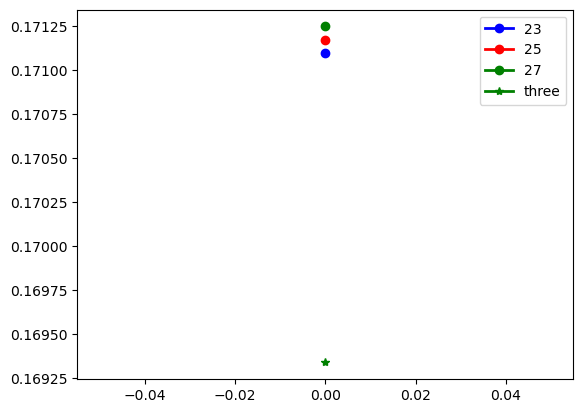

In [157]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot( vres, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.plot( vres2, marker='o', color='r', linestyle='-', linewidth=2, markersize=6,label = "25")
plt.plot( vres3, marker='o', color='g', linestyle='-', linewidth=2, markersize=6,label = "27")

plt.plot( vres4, marker='*', color='g', linestyle='-', linewidth=2, markersize=6,label = "three")
plt.legend()
plt.show()

------------------------------ 发送指令: ------------------------------ 
模式：1,指令：cim_reset
字节码：55 aa 01 0b 00 00 00 01

------------------------------ 指令发送完成！------------------------------ 

------------------------------ 发送指令: ------------------------------ 
模式：1,指令：fast_command_1
字节码：55 aa 01 01 00 00 20 00

------------------------------ 指令发送完成！------------------------------ 

DAC: adc0_outA
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outA
字节码：55 aa 02 41

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'f\x00\x00\x00'

电压int:  0.003891109958189642
DAC: adc0_outB
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outB
字节码：55 aa 02 42

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'\x9c\xfe\xff\xff'

电压int:  -0.01358073671681875
DAC: adc0_outC
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outC
字节码：55 aa 02

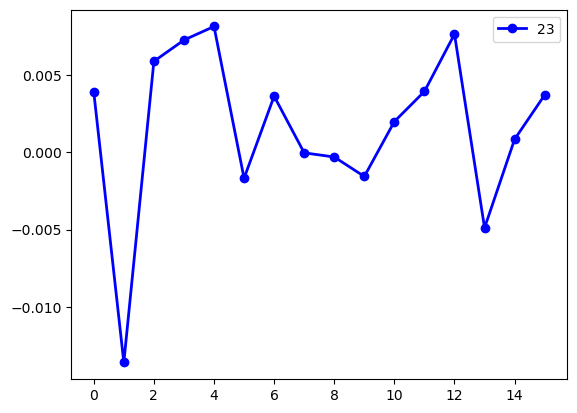

In [211]:
pkts=Packet()
pkts.append_cmdlist([CMD(CIM_RESET,command_data=CmdData(1))],mode=1)                 # reset指令
ps.send_packets(pkts)

pkts=Packet()
pkts.append_cmdlist([
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
],mode=1)
ps.send_packets(pkts)

tia16 = []
for TIA_num in range(16):
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    tia16.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)

plt.figure()
plt.plot( tia16, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.legend()
plt.show()

In [ ]:
# 31，0.319
# 33，0.3185
# 35，0.318

In [19]:
res_meas = 0.1 * (200) * 1 / voltage_sample_int
print(res_meas)
print(1/res_meas*1e6)

53.88201438848921
18559.068575090794


In [40]:
res_meas = 0.1 * (10e3+200) * 6.0241 / voltage_sample_int
print(res_meas)
# 0.11,

87681.88062885137


In [8]:
def adc_to_voltage(data, vref=1.25):
    # 将十六进制字符串转换为整数
    data = int(data, 16)
    # 确保数据在16位范围内
    data &= 0xFFFF
    # 将16位有符号数转换为Python整数
    if data & 0x8000:  # 若符号位为1，则表示负数
        data -= 0x10000

    # 将数据转换为电压
    voltage = (data / (2**15-1)) * vref  # 32767 是0x7FFF对应的正最大值
    return voltage

In [95]:
pkts=Packet()
pkts.append_cmdlist([
    CMD(CIM_RESET,command_data=CmdData(1)),                 # reset指令
],mode=1)
# 发送指令
ps.send_packets(pkts)

In [96]:

pkts=Packet()
pkts.append_cmdlist([
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
],mode=1)
chip.ps.send_packets(pkts)

TIA_num = adc.TIA_index_map(colnum,1,True)
adc_num, adc_channel = int(TIA_num/4),TIA_num%4

channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
pkts=Packet()
adc_out = CMD(dict(
    command_addr = 65+TIA_num,
    command_type = COMMAND_TYPE[1],
    n_addr_bytes = N_ADDR_BYTES[0],
    n_data_bytes = N_DATA_BYTES[0],
    command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
    command_data = CmdData(0),
    command_description = "从ADC对应通道读取数据"
))
pkts.append_cmdlist([adc_out],mode=2)

# 发送指令
ps.send_packets(pkts)
# 接收信息
# 高16bit：0，低16bit：寄存器的16bit值
message = ps.receive_packet(f"adc读取:{adc_out.command_name}")
voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
print("电压hex: ",voltage_sample_hex)
voltage_sample_int = adc_to_voltage(voltage_sample_hex)
print("电压int: ",voltage_sample_int)

---Received---
b'i\x00\x00\x00'

电压hex:  0069
电压int:  0.004005554368724631


In [45]:
def adc_to_voltage(data, vref=1.25):
    # 将十六进制字符串转换为整数
    data = int(data, 16)
    # 确保数据在16位范围内
    data &= 0xFFFF
    # 将16位有符号数转换为Python整数
    if data & 0x8000:  # 若符号位为1，则表示负数
        data -= 0x10000

    # 将数据转换为电压
    voltage = (data / (2**15-1)) * vref  # 32767 是0x7FFF对应的正最大值
    return voltage

for i in range(16):
    print("读通道",i)
    TIA_num = i
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)

    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")
    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    print("电压int: ",voltage_sample_int)

读通道 0
---Received---
b'\x95\x00\x00\x00'

电压hex:  0095
电压int:  0.005684072389904477
读通道 1
---Received---
b'\xf9\xe4\xff\xff'

电压hex:  e4f9
电压int:  -0.2639469588305307
读通道 2
---Received---
b'\xf5\x06\x00\x00'

电压hex:  06f5
电压int:  0.06794183172093875
读通道 3
---Received---
b'f,\x00\x00'

电压hex:  2c66
电压int:  0.4335917233802301
读通道 4
---Received---
b'\x9e\x11\x00\x00'

电压hex:  119e
电压int:  0.17204809717093417
读通道 5
---Received---
b'\xb4\xf3\xff\xff'

电压hex:  f3b4
电压int:  -0.12009033478804895
读通道 6
---Received---
b'\x88\x08\x00\x00'

电压hex:  0888
电压int:  0.08331553086947234
读通道 7
---Received---
b'\x0b\xfd\xff\xff'

电压hex:  fd0b
电压int:  -0.02887813959166234
读通道 8
---Received---
b'Y\xfc\xff\xff'

电压hex:  fc59
电压int:  -0.03566850795007172
读通道 9
---Received---
b'\xfd\xf5\xff\xff'

电压hex:  f5fd
电压int:  -0.097773674733726
读通道 10
---Received---
b'\n\xfc\xff\xff'

电压hex:  fc0a
电压int:  -0.038682210760826445
读通道 11
---Received---
b'\x16\x05\x00\x00'

电压hex:  0516
电压int:  0.049668874172185434
读通道 12
-

In [11]:
ps.set_debug(True)

# adc.set_sample_times(32)
# dac.set_voltage(5,0,0)
# chip.set_pulse_width(pulsewidth=255)
# chip.set_pulse_width(pulsewidth=1)